# `xarray` and `ICON`

In [1]:
import xarray as xr
xr.set_options(display_style='text')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs
import cartopy as cp

# `xoak`

- https://xoak.readthedocs.io/en/latest/examples/introduction.html
- https://xoak.readthedocs.io/en/latest/examples/dask_support.html

In [2]:
import xoak

In [3]:
def rad_to_deg(ds):
    """Convert radian units to deg."""
    #ds.coords.compute()
    for c in ds.coords:
        if 'units' in ds[c].attrs:
            if ds[c].attrs['units'] == 'radian':
                print(f'convert {c} from rad to deg')
                ds[c] = ds[c]* 180./np.pi
                ds[c].attrs['units'] = 'degrees'
        elif 'bnds' in c:
            print(f'convert {c} from rad to deg')
            ds[c] = ds[c]* 180./np.pi
            ds[c].attrs['units'] = 'degrees'
    return ds

In [4]:
#igrid = xr.open_dataset('/work/mh0727/m300732/icon-oes-hamocc/experiments/ler0956/icon_grid_0036_R02B04_O.nc')
#igrid = rad_to_deg(igrid)

In [5]:
# ICON output I want to work with
ds = xr.open_dataset('/work/mh0727/m300732/icon-oes-hamocc/experiments/ler0956/ler0956_hamocc_34500101T000000Z.nc',
                     chunks={'time': 1})

/work/mh0727/m300524/conda-envs/pymistral/lib/python3.8/site-packages/xarray/coding/times.py:463: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/work/mh0727/m300524/conda-envs/pymistral/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


In [6]:
# move from data_vars to coords
ds = ds.set_coords(['clon_bnds','clat_bnds'])

ds = rad_to_deg(ds)
# 
ds['phyp'] # ncells is dimension

convert clon from rad to deg
convert clon_bnds from rad to deg
convert clat from rad to deg
convert clat_bnds from rad to deg


<xarray.DataArray 'phyp' (time: 9, depth: 40, ncells: 15105)>
dask.array<open_dataset-bb6eb538b480d4c0b5beb7dc6190d5d3phyp, shape=(9, 40, 15105), dtype=float32, chunksize=(1, 40, 15105), chunktype=numpy.ndarray>
Coordinates:
    clon     (ncells) float32 dask.array<chunksize=(15105,), meta=np.ndarray>
    clat     (ncells) float32 dask.array<chunksize=(15105,), meta=np.ndarray>
  * depth    (depth) float64 6.0 17.0 27.0 37.0 ... 4.67e+03 5.17e+03 5.72e+03
  * time     (time) object 3451-01-01 00:00:00 ... 3459-01-01 00:00:00
Dimensions without coordinates: ncells
Attributes:
    standard_name:                phyp
    long_name:                    phytoplankton concentration
    units:                        kmolP m-3
    code:                         6
    CDI_grid_type:                unstructured
    number_of_grid_in_reference:  1

In [7]:
# new grid I want to work on
mpiom_grid = xr.open_dataset('/home/mpim/m300524/mpiom_fx.nc')

## remap with xoak

In [8]:
# set xoak index
ds.xoak.set_index(['clat', 'clon'], 'sklearn_geo_balltree')

In [9]:

from dask.diagnostics import ProgressBar
import dask
with ProgressBar(), dask.config.set(scheduler='processes'):
    ds_selection = ds.xoak.sel(clat=mpiom_grid.lat, clon=mpiom_grid.lon)

# %time ds_selection = ds.xoak.sel(clat=mpiom_grid.lat, clon=mpiom_grid.lon) # also runs without dask scheduler
print('remapping',ds.nbytes/1e6,'MB  to ',ds_selection.nbytes/1e6,'MB')

[########################################] | 100% Completed |  8.0s
remapping 479.010152 MB  to  1786.020232 MB


In [10]:
# all lazy dask arrays
ds_selection['phyp'] # ncells is no dimension anymore, but x and y

<xarray.DataArray 'phyp' (time: 9, depth: 40, y: 220, x: 256)>
dask.array<transpose, shape=(9, 40, 220, 256), dtype=float32, chunksize=(1, 40, 220, 256), chunktype=numpy.ndarray>
Coordinates:
    clon     (y, x) float32 dask.array<chunksize=(220, 256), meta=np.ndarray>
    clat     (y, x) float32 dask.array<chunksize=(220, 256), meta=np.ndarray>
  * depth    (depth) float64 6.0 17.0 27.0 37.0 ... 4.67e+03 5.17e+03 5.72e+03
  * time     (time) object 3451-01-01 00:00:00 ... 3459-01-01 00:00:00
Dimensions without coordinates: y, x
Attributes:
    standard_name:                phyp
    long_name:                    phytoplankton concentration
    units:                        kmolP m-3
    code:                         6
    CDI_grid_type:                unstructured
    number_of_grid_in_reference:  1

## plot remapped with `xarray.plot()`

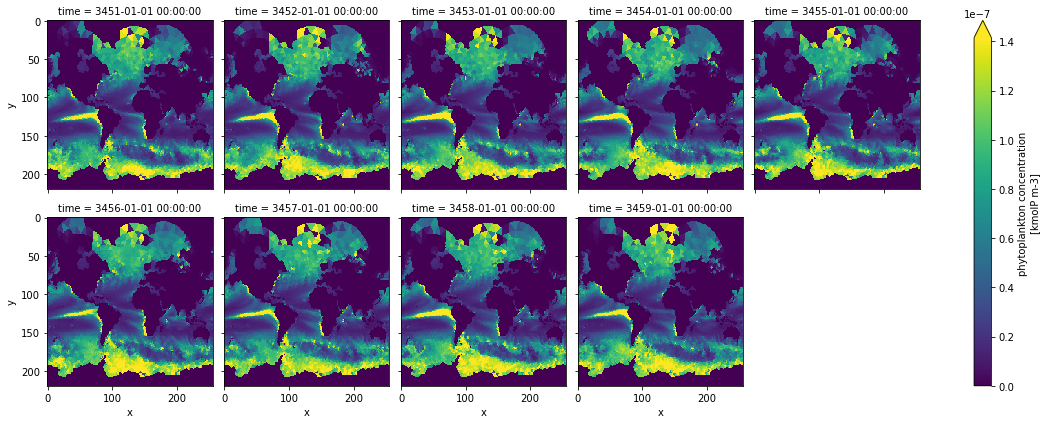

In [11]:
ds_selection['phyp'].isel(depth=0).plot(col='time', col_wrap=5, robust=True, yincrease=False)

## plot remapped with `pymistral.plot()` wrapping xarray and cartopy

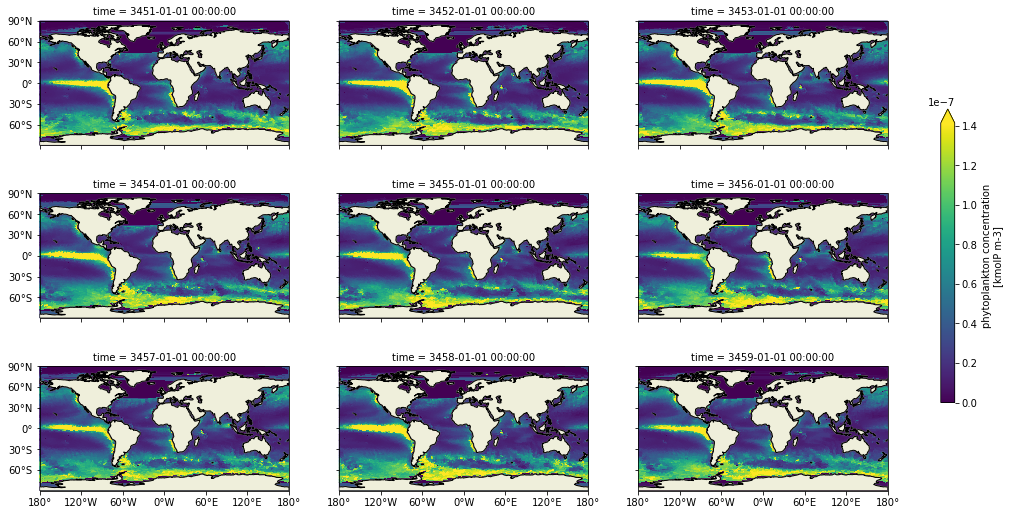

In [12]:
import pymistral
ds_selection['phyp'].isel(depth=0).rename({'clon':'lon','clat':'lat'}).compute().plot_map(col='time',col_wrap=3,robust=True, aspect=2, feature='land')

# Triangular plotting

plotting the triangles with `plt.tripcolor` from `xarray`

- could be handle by accessor: http://xarray.pydata.org/en/stable/internals/extending-xarray.html
- rewrite nicer with xarray instead of np commands where possible

In [13]:
@xr.register_dataset_accessor('icon')
class CartopyMap(object):
    def __init__(self, xarray_obj):
        self._obj = xarray_obj

    def plot(self,
             v=None,
             ax=None,
             proj=ccrs.PlateCarree(),
             robust=False,
             **tripcolor_kwargs
        ):
        """
        Plot the variable v from an xr.Dataset.
        
        Note: xr.DataArray.icon.plot() would be nicer,
        but the xr.DataArray doesnt carry the neccessary clon_bnds and clat_bnds coords.
        
        Also having some issues how to get the plot nice without buggy triangle,
        but that happened also in matplotlib.
        
        Ideally, this plot function could work like xr.DataArray.plot(col, row, vmin, vmax, robust, ...)
        """
        da = self._obj
        # --- Triangulation
        ntr = da.clon.size
        clon_bnds_rs = da['clon_bnds'].values.reshape(ntr*3)
        clat_bnds_rs = da['clat_bnds'].values.reshape(ntr*3)
        triangles = np.arange(ntr*3).reshape(ntr,3)
        Tri = matplotlib.tri.Triangulation(clon_bnds_rs, clat_bnds_rs, triangles=triangles)

        if isinstance(da,xr.Dataset):
            if v is None:
                v=list(da.data_vars)
                if len(v)>0:
                    v=v[0] # take first variable
                    da=da[v]
            else:
                da=da[v]

        vmin = tripcolor_kwargs.pop('vmin',None)
        vmax = tripcolor_kwargs.pop('vmax',None)
        if vmin is None and vmax is None and robust:
            vmin = da.quantile(0.02).values
            vmax = da.quantile(.98).values
        
        # what if more than two dims: see xr.facetgrid
        fig, axes = plt.subplots(subplot_kw=dict(projection=proj),figsize=(8,4))
        # best would be to add tripcolor to xarray
        hm = axes.tripcolor(Tri,
                            da,
                            vmin=vmin,
                            vmax=vmax,
                            #edgecolors='k',
                            #lw=0.01,
                            transform=ccrs.PlateCarree(),
                            alpha=.5,
                            **tripcolor_kwargs
                            )
        # now add features, labels etc
        axes.add_feature(cp.feature.LAND, zorder=0)
        #axes.set_extent((-178, 178, -88, 88), crs=ccrs.PlateCarree())
        cb = plt.colorbar(mappable=hm, ax=axes, extend='both')
        ## use metadata
        title_str = ''
        title_labels = [c for c in da.coords if da.coords[c].size == 1]
        for l in title_labels:
            title_str += f', {l} = {str(da[l].astype(str).values)}'
        axes.set_title(title_str[1:])
        cb.set_label(f'{da.attrs["long_name"]}\n[{da.attrs["units"]}]', rotation = 90)
        # add x,y ticks and labels
        return axes

<GeoAxesSubplot:title={'center':' depth = 6.0, time = 3453-01-01 00:00:00'}>

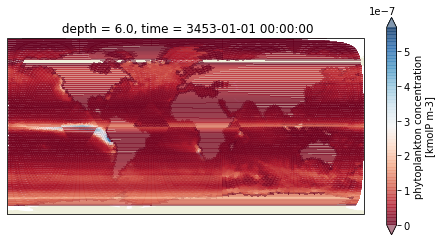

In [14]:
ds.isel(depth=0,time=2).icon.plot('phyp', cmap='RdBu')

<GeoAxesSubplot:title={'center':' depth = 6.0, time = 3453-01-01 00:00:00'}>

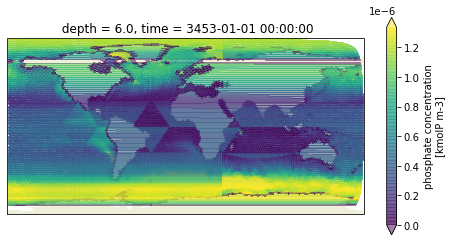

In [15]:
ds.isel(depth=0,time=2).icon.plot('po4', robust=True)